In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_num = 1
phase = 3


model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='paul')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

Directory '/Users/mahdiyarshahbazi/Documents/Data/MotorNet/paul' already exists.


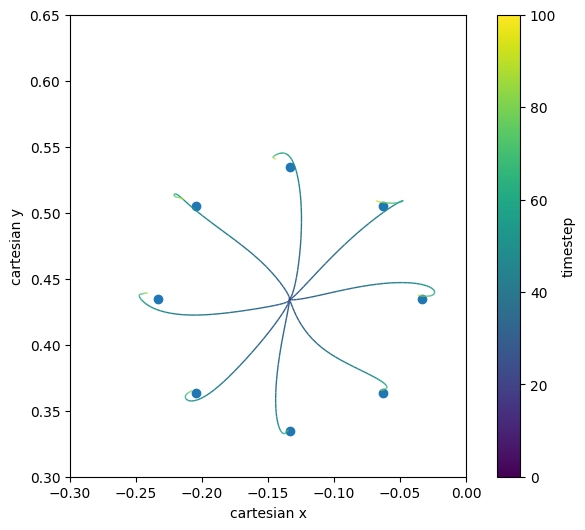

In [3]:
xy, tg, all_hidden, all_muscles = test(cfg_file,weight_file,ff_coefficient=0)
fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg,figsize=(8,6))

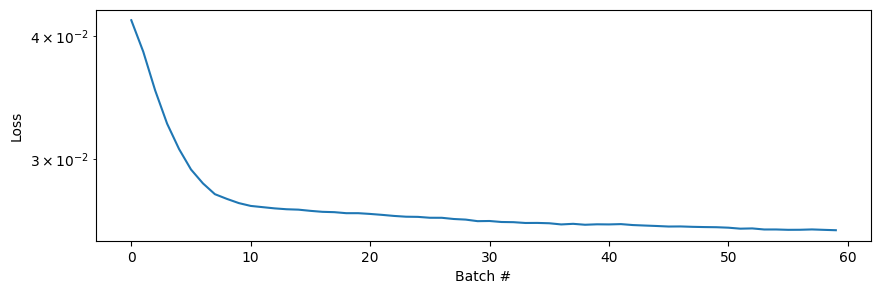

In [4]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log)

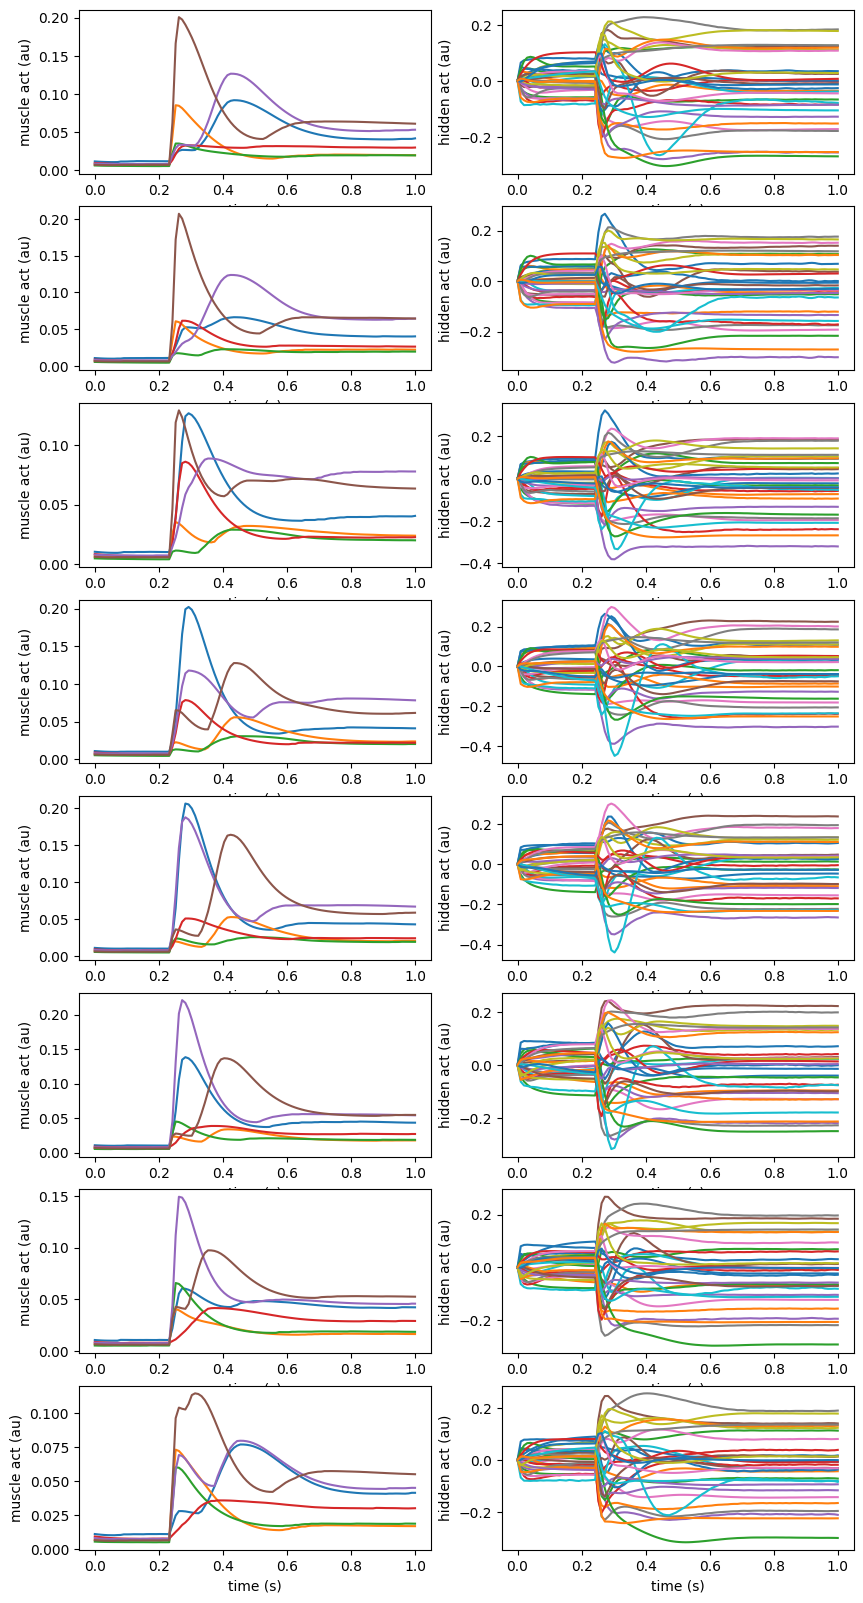

In [5]:
fig, ax = plot.plot_activation(all_hidden, all_muscles)
#fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)

In [6]:
# Perform PCA on network hidden units trajectories
all_hidden = np.array(all_hidden)
n_mean = np.mean(all_hidden, axis=0, keepdims=True)
rate_scaled = (all_hidden - n_mean)

transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled, method='FA')

X_ld = transform.transform(rate_scaled, ensure_orthogonality=True)

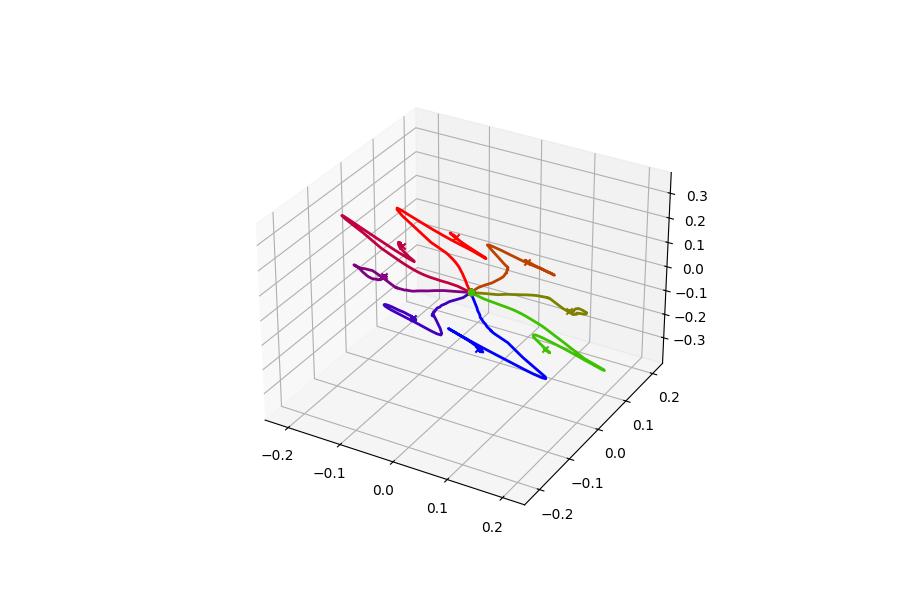

In [7]:
angle_set = np.deg2rad(np.arange(0,360,45)) # 8 directions
reach_angles = []
for cond in angle_set:
    reach_angles.append(plt.cm.brg(cond/(2*np.pi)))

#%matplotlib widget
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111,projection='3d')
for c in range(8):
    ax.plot(X_ld[c,:,0],X_ld[c,:,1],X_ld[c,:,2],lw=2,c=reach_angles[c])
    ax.scatter(X_ld[c,0,0],X_ld[c,0,1],X_ld[c,0,2],color=reach_angles[c])
    ax.scatter(X_ld[c,-1,0],X_ld[c,-1,1],X_ld[c,-1,2],marker='x',color=reach_angles[c])